In [ ]:
pip install ucimlrepo

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
from ucimlrepo import fetch_ucirepo

# Fetch dataset
online_shoppers_purchasing_intention_dataset = fetch_ucirepo(id=468)
X = online_shoppers_purchasing_intention_dataset.data.features
y = online_shoppers_purchasing_intention_dataset.data.targets.squeeze()


In [ ]:
# Check for null values in features and targets
print("Checking for null values in features:")
print(X.isnull().sum())
print("\nChecking for null values in targets:")
print(y.isnull().sum())

Checking for null values in features:
Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
dtype: int64

Checking for null values in targets:
0


In [ ]:
# Encode categorical and boolean variables, standardize features
le = LabelEncoder()
scaler = StandardScaler()

# Encode categorical variables
for column in ['Month', 'VisitorType']:
    if X[column].dtype == 'object':
        X[column] = le.fit_transform(X[column])

# Convert boolean to int
if X['Weekend'].dtype == 'bool':
    X['Weekend'] = X['Weekend'].astype(int)

# Standardize the features
X_scaled = scaler.fit_transform(X)

<ipython-input-4-8bfe0d4582d7>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = le.fit_transform(X[column])
<ipython-input-4-8bfe0d4582d7>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = le.fit_transform(X[column])
<ipython-input-4-8bfe0d4582d7>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

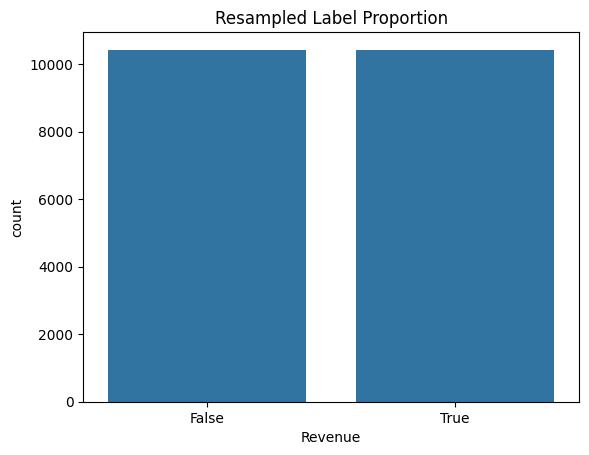

In [ ]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Visualize resampled label proportion
sns.countplot(x=y_resampled)
plt.title("Resampled Label Proportion")
plt.show()

In [ ]:
# Setup LightGBM and hyperparameters grid
lgbm = lgb.LGBMClassifier(random_state=42)
param_grid = {
    'num_leaves': [31, 50],
    'max_depth': [-1, 10, 20],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200]
}

# Setup GridSearchCV
kf = KFold(n_splits=3, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, scoring='f1', cv=kf, verbose=1, n_jobs=-1)
grid_search.fit(X_resampled, y_resampled)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[LightGBM] [Info] Number of positive: 10422, number of negative: 10422
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003531 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3793
[LightGBM] [Info] Number of data points in the train set: 20844, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             estimator=LGBMClassifier(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [-1, 10, 20], 'n_estimators': [100, 200],
                         'num_leaves': [31, 50]},
             scoring='f1', verbose=1)

In [ ]:
# Display best parameters
print("Best parameters found: ", grid_search.best_params_)
best_lgbm = grid_search.best_estimator_

Best parameters found:  {'learning_rate': 0.2, 'max_depth': 20, 'n_estimators': 200, 'num_leaves': 50}


[LightGBM] [Info] Number of positive: 8315, number of negative: 8360
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002602 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3758
[LightGBM] [Info] Number of data points in the train set: 16675, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498651 -> initscore=-0.005397
[LightGBM] [Info] Start training from score -0.005397

Confusion Matrix:
[[1938  124]
 [ 104 2003]]


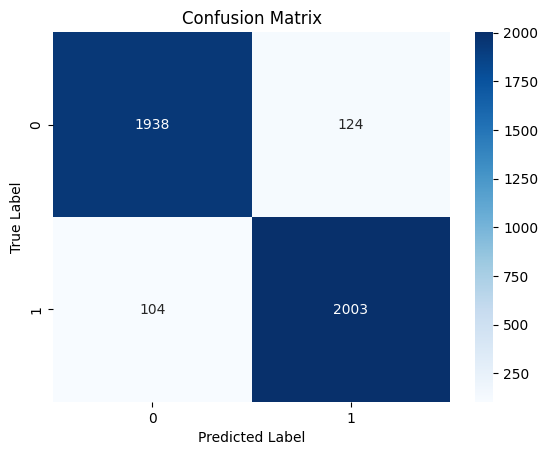

In [ ]:
# Train and evaluate the model
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
best_lgbm.fit(X_train, y_train)
y_pred = best_lgbm.predict(X_test)

# Confusion matrix and classification report
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
# Classification report and accuracy/F1 score
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Display results in a DataFrame
results = pd.DataFrame({
    'Model': ['LightGBM'],
    'Accuracy': [accuracy],
    'F1 Score': [f1]
})
print("\nAccuracy and F1 Score table:")
print(results)


Classification Report:
              precision    recall  f1-score   support

       False       0.95      0.94      0.94      2062
        True       0.94      0.95      0.95      2107

    accuracy                           0.95      4169
   macro avg       0.95      0.95      0.95      4169
weighted avg       0.95      0.95      0.95      4169


Accuracy and F1 Score table:
      Model  Accuracy  F1 Score
0  LightGBM  0.945311   0.94615
